In [1]:
import pandas as pd
import numpy as np
import json
import pandas as pd
import re
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import Counter,defaultdict
from ast import literal_eval
import cobra
import multiprocessing
from functools import partial
sys.path.append('../retrosynthesis/')
import matplotlib.pyplot as plt

from common import *

import sys
# sys.path.append('../Script/')
# from check_newinfo_getyeast8U import *

import warnings
warnings.filterwarnings('ignore', 'A value is trying to be set on a copy of a slice from a DataFrame')

In [2]:
### input
# yeast870_path =  '../../Data/model/yeast-GEM.mat'
yeast8U_path = '../../Data/model/yeast8U_del2_re.yml'
uniprot_sce_path = '../../Data/uniprot/uniprotkb_organism_id_559292_2023_11_08.tsv'

metabolites_info_to_GEM_path = '../../Results/not_lipid/top50_0.3_re/metabolites_info_to_GEM_top50_0.3.csv'
rxndb_total_info_to_model_path = '../../Results/not_lipid/top50_0.3_re/rxndb_total_info_to_model_top50_0.3.csv'

### output
uniprot_reaction_path = '../../Data/uniprot/uniprot_reaction_smiles.csv'
figs4_c_path = '../../Results/Figures/figs4_c.pdf'


# uniprot

In [7]:
uniprot_sce_entry = pd.read_csv(uniprot_sce_path,sep='\t')
uniprot_sce_entry = uniprot_sce_entry['Entry'].to_list()
len(uniprot_sce_entry)

6735

In [30]:
uniprot_reaction = pd.read_csv(uniprot_reaction_path)
uniprot_sce_reaction = uniprot_reaction[uniprot_reaction['Entry'].isin(uniprot_sce_entry)]
uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:literal_eval(x))
print(uniprot_sce_reaction.shape)
uniprot_sce_reaction

(1380, 6)


/tmp/ipykernel_2656661/1850127756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:literal_eval(x))


,Entry,Reviewed,Entry Name,Catalytic activity,reaction_rhea_id,reaction_smiles
38,A0A0B7P3V8,reviewed,YP41B_YEAST,CATALYTIC ACTIVITY: Reaction=a 2'-deoxyribonuc...,"['22508', 22509, 22510]",{'22509': '*[C@H]1C[C@H](O)[C@@H](COP(=O)([O-]...
1927,O13297,reviewed,CET1_YEAST,CATALYTIC ACTIVITY: Reaction=a 5'-end triphosp...,"['67005', 67005, 67006]",{'67005': '*O[C@H]1[C@@H](O)[C@H](*)O[C@@H]1CO...
1936,O13527,reviewed,YA11B_YEAST,CATALYTIC ACTIVITY: Reaction=a 2'-deoxyribonuc...,"['22508', 22509, 22510]",{'22509': '*[C@H]1C[C@H](O)[C@@H](COP(=O)([O-]...
1937,O13535,reviewed,YH11B_YEAST,CATALYTIC ACTIVITY: Reaction=a 2'-deoxyribonuc...,"['22508', 22509, 22510]",{'22509': '*[C@H]1C[C@H](O)[C@@H](COP(=O)([O-]...
3279,P00163,reviewed,CYB_YEAST,CATALYTIC ACTIVITY: Reaction=a quinol + 2 Fe(I...,"[11485, 11486]",{'11485': '[1*]C1=C(O)C([4*])=C([3*])C(O)=C1[2...
...,...,...,...,...,...,...
199891,P38635,reviewed,HIS9_YEAST,CATALYTIC ACTIVITY: Reaction=H2O + L-histidino...,"[14466, 14467]",{'14466': '[H]O[H].[NH3+][C@H](COP(=O)([O-])[O...
199892,P38709,reviewed,UGPA2_YEAST,CATALYTIC ACTIVITY: Reaction=alpha-D-glucose 1...,"[19890, 19891]",{'19890': 'O=C1C=CN([C@@H]2O[C@H](COP(=O)([O-]...
199893,P38744,reviewed,PHS_YEAST,"CATALYTIC ACTIVITY: Reaction=(4aS,6R)-4a-hydro...","[11921, 11922]",{'11921': 'C[C@H](O)[C@H](O)[C@H]1CNC2=NC(N)=N...
200218,P47145,reviewed,LIH1_YEAST,CATALYTIC ACTIVITY: Reaction=a triacylglycerol...,"['12045', 12045, 12046]",{'12045': '[1*]C(=O)OCC(COC([3*])=O)OC([2*])=O...


In [31]:
uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:{k:v for k,v in x.items() if 'R' not in v})
print(uniprot_sce_reaction.shape)
uniprot_sce_reaction = uniprot_sce_reaction[uniprot_sce_reaction['reaction_smiles'].apply(lambda x:x!={})]
print(uniprot_sce_reaction.shape)

(1380, 6)
(1376, 6)


/tmp/ipykernel_2656661/2666421269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:{k:v for k,v in x.items() if 'R' not in v})


In [32]:
uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:{k:v for k,v in x.items() if '*' not in v})
print(uniprot_sce_reaction.shape)
uniprot_sce_reaction = uniprot_sce_reaction[uniprot_sce_reaction['reaction_smiles'].apply(lambda x:x!={})]
print(uniprot_sce_reaction.shape)

(1376, 6)
(755, 6)


/tmp/ipykernel_2656661/3109199355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniprot_sce_reaction['reaction_smiles'] = uniprot_sce_reaction['reaction_smiles'].apply(lambda x:{k:v for k,v in x.items() if '*' not in v})


In [33]:
uniprot_sce_reaction.head(3)

,Entry,Reviewed,Entry Name,Catalytic activity,reaction_rhea_id,reaction_smiles
3280,P00175,reviewed,CYB2_YEAST,CATALYTIC ACTIVITY: Reaction=(S)-lactate + 2 F...,"['19910', 19910, 19911]",{'19910': 'C[C@H](O)C(=O)[O-].[Fe+3].[Fe+3]>>C...
3310,P00358,reviewed,G3P2_YEAST,CATALYTIC ACTIVITY: Reaction=D-glyceraldehyde ...,"[10301, 10302]",{'10301': 'NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP...
3311,P00359,reviewed,G3P3_YEAST,CATALYTIC ACTIVITY: Reaction=D-glyceraldehyde ...,"[10301, 10302]",{'10301': 'NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP...


## Generate similar rxndb_df

In [34]:
uniprot_sce_reaction_df = pd.DataFrame(columns=['NO','RheaID','rxn_smiles_final'])
for index, row in tqdm(uniprot_sce_reaction.iterrows(),total = len(uniprot_sce_reaction)):
    num = 1
    for k, v in row['reaction_smiles'].items():
        new_row = {}
        new_row['NO'] = row['Entry'] + '_' + str(num)
        new_row['RheaID'] = k
        new_row['rxn_smiles_final'] = v
        uniprot_sce_reaction_df = uniprot_sce_reaction_df._append(new_row, ignore_index=True)
        num += 1
        
uniprot_sce_reaction_df.head(3)

100%|██████████| 755/755 [00:01<00:00, 658.55it/s]


,NO,RheaID,rxn_smiles_final
0,P00175_1,19910,C[C@H](O)C(=O)[O-].[Fe+3].[Fe+3]>>CC(=O)C(=O)[...
1,P00175_2,19911,CC(=O)C(=O)[O-].[Fe+2].[Fe+2].[H+].[H+]>>C[C@H...
2,P00358_1,10301,NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP(=O)([O-])O...


# uniprot smiles list and rxndb smiles list

In [35]:


def compare_reaction_smiles_pair(smiles1,smiles2):
    smiles1_lst = smiles1.replace('>>','.').split('.')
    smiles1_lst = list(set([x for x in smiles1_lst if  smiles_has_carbon(x)]))

    smiles2_lst = smiles2.replace('>>','.').split('.')
    smiles2_lst = list(set([x for x in smiles2_lst if  smiles_has_carbon(x)]))

    if len(smiles1_lst)==len(smiles2_lst):
        score = 0
        for s1 in smiles1_lst:
            if any(compare_smiles_inchikey(s1,s2) for s2 in smiles2_lst):
                score += 1
            else:
                score += 0
        if score == len(smiles1_lst):
            return True
        else:
            return False
    else:
        return False

In [36]:
# nocarbon_list = []
# for i in uniprot_sce_reaction_df['rxn_smiles_final']:
#     smiles_lst = i.replace('>>','.').split('.')
#     for smiles in smiles_lst:
#         if not smiles_has_carbon(smiles):
#             nocarbon_list.append(smiles)

In [37]:
rxndb_total_info_to_model = pd.read_csv(rxndb_total_info_to_model_path)
rxndb_total_info_to_model = rxndb_total_info_to_model[['NO','EC_number','templateID','rxn_smiles_final','GPR']]
rxndb_total_info_to_model.head(3)

,NO,EC_number,templateID,rxn_smiles_final,GPR
0,rxn21129,1.13.11,MNXR138980_reverse,O.O=C1OC(CO)C([O-])=C1O.O=O>>O=C([O-])C(O)CO.O...,(YMR009W) or (YJR078W) or (YJR025C)
1,rxn21142,"1.14.13, 1.14.18",MNXR107479_reverse,O.OCCc1ccc(O)cc1.NC(=O)c1ccc[n+]([C@@H]2O[C@H]...,(YBL098W) or (YNR053C) or (YCL059C) or (YHR176...
2,rxn21172,1.14.14,MNXR192363_reverse,O=O.Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2.Cc...,(YCL001W) or (YHR007C) or (YAL064W) or (YGR175...


In [ ]:
rxndb_smiles_lst = []
for index,row in rxndb_total_info_to_model.iterrows():
    smiles_lst = row['rxn_smiles_final'].replace('>>','.').split('.')
    rxndb_smiles_lst +=smiles_lst
rxndb_smiles_lst = [normalize_smiles(x) for x in rxndb_smiles_lst]
rxndb_smiles_lst = list(set(rxndb_smiles_lst))

uniprot_smiles_lst = []
for index,row in uniprot_sce_reaction_df.iterrows():
    smiles_lst = row['rxn_smiles_final'].replace('>>','.').split('.')
    uniprot_smiles_lst +=smiles_lst
# uniprot_smiles_lst = [normalize_smiles(x) for x in rxndb_smiles_lst]
uniprot_smiles_lst = list(set(uniprot_smiles_lst))

error_smiles = []
for met in tqdm(uniprot_smiles_lst,total=len(uniprot_smiles_lst)):
    if any(compare_smiles_inchikey(met,smiles) for smiles in rxndb_smiles_lst):
        pass
    else:
        error_smiles.append(met)

print(len(error_smiles))
error_smiles = [x for x in error_smiles if smiles_has_carbon(x)]
print(len(error_smiles))

In [ ]:
for smiles in error_smiles:
    uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].apply(lambda x: smiles in x.replace('>>', '.').split('.'))]
print(uniprot_sce_reaction_df.shape)

(1654, 3)


In [ ]:
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Fe\+2\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Zn\+2\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Ca\+2\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Cu\+\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[K\+\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Cd\+2\]')]
uniprot_sce_reaction_df = uniprot_sce_reaction_df[~uniprot_sce_reaction_df['rxn_smiles_final'].str.contains(r'\[Cu\+2\]')]
print(uniprot_sce_reaction_df.shape)

(1570, 3)


In [ ]:

# Function executed by each process
def match_reactions(row1, rxndb_total_info_to_model):
    reaction_match = []
    for _, row2 in rxndb_total_info_to_model.iterrows():
        if compare_reaction_smiles_pair(row1['rxn_smiles_final'], row2['rxn_smiles_final']):
            reaction_match.append(row2['NO'])
    return row1['NO'], reaction_match

# Only process the first 50 rows
# uniprot_sce_reaction_df = uniprot_sce_reaction_df.head(50)

num_processes = 30
pool = multiprocessing.Pool(num_processes)

# Use partial to pass rxndb_total_info_to_model to match_reactions
match_reactions_partial = partial(match_reactions, rxndb_total_info_to_model=rxndb_total_info_to_model)

# Parallel processing
result = list(tqdm(pool.imap(match_reactions_partial, [row for _, row in uniprot_sce_reaction_df.iterrows()]), total=len(uniprot_sce_reaction_df)))

100%|██████████| 1570/1570 [48:02<00:00,  1.84s/it] 


In [ ]:
reaction_match_dict = {no: match for no, match in result}

In [ ]:
print(len(reaction_match_dict))

num = 0
for k,v in reaction_match_dict.items():
    if len(v)>0:
        num +=1
num

1570


1242

In [ ]:
num / len(reaction_match_dict)

0.7910828025477707

In [ ]:
reaction_match_dict = {k:v for k,v in reaction_match_dict.items() if len(v)>0}

In [ ]:

uniprot_data = pd.read_csv(uniprot_sce_path,sep='\t')
uniprot_data = uniprot_data[~uniprot_data['Gene Names'].isna()]
uniprot_data.head(3)

entry2geneID = {}
for index,row in uniprot_data.iterrows():
    uniprot_gene_lst = row['Gene Names'].split(' ')
    entry2geneID [row['Entry']] = uniprot_gene_lst


entry2geneID = {k:v for k,v in entry2geneID.items() if len(v)>0}
entry2geneID

{'A0A0B7P3V8': ['TY4B-P', 'YPLCTy4-1', 'POL', 'YPL060C-A'],
 'D6VTK4': ['STE2', 'YFL026W'],
 'O13297': ['CET1', 'YPL228W', 'P1433'],
 'O13329': ['FOB1', 'HRM1', 'YDR110W', 'YD9727.06'],
 'O13516': ['RPS9A', 'RPS13A', 'YS11A', 'YPL081W'],
 'O13527': ['TY1B-A', 'YARCTy1-1', 'POL', 'YAR009C'],
 'O13535': ['TY1B-H', 'YHRCTy1-1', 'POL', 'YHR214C-B'],
 'O13547': ['CCW14', 'ICWP', 'SSR1', 'YLR390W-A', 'YLR391W-A'],
 'O13563': ['RPN13', 'DAQ1', 'YLR421C'],
 'O14467': ['MBF1', 'SUF13', 'YOR298C-A'],
 'O60200': ['MDM35', 'YKL053C-A'],
 'O74700': ['TIM9', 'YEL020W-A', 'YEL020BW'],
 'O94742': ['SEM1', 'DSH1', 'YDR363W-A'],
 'P00044': ['CYC1', 'YJR048W', 'J1653'],
 'P00045': ['CYC7', 'CYP3', 'YEL039C'],
 'P00127': ['QCR6', 'UCR6', 'YFR033C'],
 'P00128': ['QCR7', 'CRO1', 'UCR7', 'YDR529C', 'D9719.32'],
 'P00163': ['COB', 'CYTB', 'Q0105'],
 'P00175': ['CYB2', 'YML054C', 'YM9958.08C'],
 'P00330': ['ADH1', 'ADC1', 'YOL086C', 'O0947'],
 'P00331': ['ADH2', 'ADR2', 'YMR303C', 'YM9952.05C'],
 'P00358': ['T

In [ ]:
def rxn2geneID(rxnlst,rxndb_total_info_to_model):
    genelst = []
    for i in rxnlst:
        tmp = rxndb_total_info_to_model[rxndb_total_info_to_model['NO']==i]['GPR'].to_list()[0]
        tmp = tmp.replace(')','').replace('(','').split(' or ')
        genelst += tmp
    return list(set(genelst))

In [ ]:
success_gpr_num = 0
for k,v in tqdm(reaction_match_dict.items(),total=len(reaction_match_dict)):
    if len(v)>0:
        uniprot_gene_list = entry2geneID[k.split('_')[0]]
        rxndb_gene_list = rxn2geneID(v,rxndb_total_info_to_model)
        if len(set(rxndb_gene_list).intersection(uniprot_gene_list)) > 0:
            success_gpr_num += 1

success_gpr_num

100%|██████████| 1242/1242 [00:01<00:00, 1189.53it/s]


1055

In [27]:
1055/1242


0.8494363929146538

In [3]:
uniprot_reaction_ratio = 0.791
uniprot_gpr_ratio = 0.849

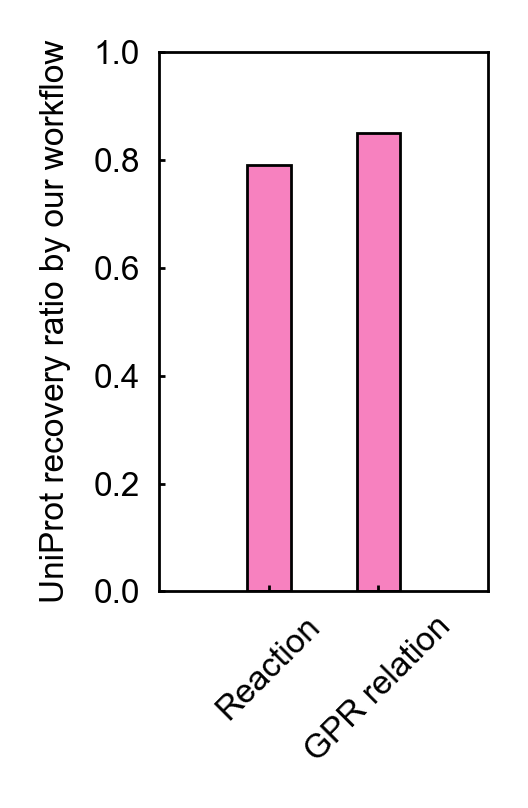

In [4]:
# Set general parameters
plt.figure(figsize=(1.3, 2), dpi=400)
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Set axis styles
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# Data
labels = ['Reaction', 'GPR relation']
data2 = [uniprot_reaction_ratio, uniprot_gpr_ratio]

# Create bar chart
width = 0.4

plt.bar([1, 2], data2, color='#f781bf', width=width, edgecolor='black', linewidth=0.5)

# Set axis parameters
plt.tick_params(axis='y', direction='in', width=0.5, which='both', length=1)
plt.tick_params(axis='x', direction='in', width=0.5, which='both', length=1)
plt.xlim(0, 3)
plt.ylim(0, 1)

# Set x-axis labels
plt.xticks([1, 2], labels, rotation=45)

# Set labels and title
# plt.xlabel('UniProt recovery ratio by our workflow', fontsize=6)
plt.ylabel('UniProt recovery ratio by our workflow', fontsize=6)

plt.tight_layout()

# Save the figure
plt.savefig(figs4_c_path, dpi=400)

# Show the figure
plt.show()